In [2]:
#import modules
import pandas as pd # for dataframes
import matplotlib.pyplot as plt # for plotting graphs
import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np
%matplotlib inline

In [3]:
#load analytics data
history_data = pd.read_csv('data.csv')

/home/ajit/ml/ml-env/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3062: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
history_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 801810 entries, 0 to 801809
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   action_type   801810 non-null  object 
 1   user_type     801810 non-null  object 
 2   epoch         801810 non-null  object 
 3   object_id     801793 non-null  object 
 4   user_id       6299 non-null    object 
 5   sid           801810 non-null  float64
 6   og_url        801810 non-null  object 
 7   tt_id         801810 non-null  int64  
 8   sub_account   801810 non-null  object 
 9   utm_source    38674 non-null   object 
 10  utm_campaign  193171 non-null  object 
 11  utm_medium    193171 non-null  object 
 12  referrer      360085 non-null  object 
 13  utm_content   3970 non-null    object 
 14  latitude      801810 non-null  float64
 15  longitude     801810 non-null  float64
 16  useragent     801809 non-null  object 
 17  variant_id    327644 non-null  object 
dtypes: f

In [5]:
# checking null data
history_data.isnull().sum(axis=0)

action_type          0
user_type            0
epoch                0
object_id           17
user_id         795511
sid                  0
og_url               0
tt_id                0
sub_account          0
utm_source      763136
utm_campaign    608639
utm_medium      608639
referrer        441725
utm_content     797840
latitude             0
longitude            0
useragent            1
variant_id      474166
dtype: int64

In [6]:
history_data.shape

(801810, 18)

In [7]:
# Checking unique users
history_data.tt_id.nunique()

179168

In [8]:
history_data['epoch'] =  pd.to_datetime(history_data['epoch'])

history_data['epoch'].min(), history_data['epoch'].max() 

# 5 days tracking data

(Timestamp('2019-11-27 00:10:48'), Timestamp('2019-12-01 00:02:39'))

In [9]:
history_data.action_type.value_counts()

view                    796899
add_to_cart               4045
remove_from_cart           395
add_to_wishlist            208
place_order                136
register                   110
remove_from_wishlist        17
Name: action_type, dtype: int64

In [10]:
# trying to deal with unbalanced data - Resampling

A = history_data.drop('action_type',axis=1)
b = history_data['action_type']

from collections import Counter

from sklearn.datasets import load_iris
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split

from imblearn.datasets import make_imbalance
from imblearn.under_sampling import NearMiss
from imblearn.pipeline import make_pipeline
from imblearn.metrics import classification_report_imbalanced

RANDOM_STATE = 42

X, y = make_imbalance(history_data, history_data['action_type'],
                      sampling_strategy={
                          "view": 50,
                          "add_to_cart": 50,
                          "place_order": 50,
                          "remove_from_cart":50,
                          "add_to_wishlist":50,
                          "register":50,
                          "remove_from_wishlist":17
                          
                      },
                      random_state=RANDOM_STATE)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=RANDOM_STATE)

print('Training target statistics: {}'.format(Counter(y_train)))
print('Testing target statistics: {}'.format(Counter(y_test)))



Training target statistics: Counter({'view': 40, 'add_to_cart': 38, 'add_to_wishlist': 37, 'register': 36, 'place_order': 36, 'remove_from_cart': 35, 'remove_from_wishlist': 15})
Testing target statistics: Counter({'remove_from_cart': 15, 'place_order': 14, 'register': 14, 'add_to_wishlist': 13, 'add_to_cart': 12, 'view': 10, 'remove_from_wishlist': 2})


In [11]:

#pipeline = make_pipeline(NearMiss(version=2),
                        # LinearSVC(random_state=RANDOM_STATE))
#pipeline.fit(X_train, y_train)

# Classify and report the results
#print(classification_report_imbalanced(y_test, pipeline.predict(X_test)))

## User Behaviour Analytics
### Fields Used : 
    - action type - action performed by user such as view, add to wishlist etc
    - epoch - timestamp 
    - sid - session id
    - tt_id - user id
    - og_url - url 
### Using RFM behaviour based approach

In [14]:
# Taking only required fields
ua = history_data[['tt_id','sid','action_type','epoch','og_url']]

In [15]:
def isOrderPlaced(action):
   
    if "place_order" in action:
        return action
    else:
        return 0
print(X_train.shape)    

X_train['order_placed'] = X_train[['action_type']].apply(isOrderPlaced)

# Trained data 
X_train.action_type.value_counts()[:10].plot(kind='bar')

X_train.columns

(212, 18)


<ipython-input-15-179881340a1c>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train['order_placed'] = X_train[['action_type']].apply(isOrderPlaced)


Index(['action_type', 'user_type', 'epoch', 'object_id', 'user_id', 'sid',
       'og_url', 'tt_id', 'sub_account', 'utm_source', 'utm_campaign',
       'utm_medium', 'referrer', 'utm_content', 'latitude', 'longitude',
       'useragent', 'variant_id', 'order_placed'],
      dtype='object')

In [16]:
#  top_users_by_orders = ua.groupby('tt_id').sort_values('orders_placed',ascending=False)

X_train.groupby(['tt_id','sid'])['order_placed'].aggregate('count') \
        .reset_index() \
        .sort_values('order_placed',ascending=False)

tt_id       sid  order_placed
0    1556457343936  0.685319             0
118  1574925093699  0.936676             0
110  1574914076136  0.016237             0
111  1574914104769  0.760253             0
112  1574914722880  0.393964             0
..             ...       ...           ...
58   1573711582748  0.126345             0
59   1573796951607  0.829964             0
60   1573873720571  0.147517             0
61   1573917007807  0.440065             0
171  1575147834091  0.656723             0

[172 rows x 3 columns]

In [17]:
PRESENT = dt.datetime(2019,12,2)

In [18]:
import json
import random
# Test purpose only
ua = X_train

# noise to add instead of 0 for creating unique bins
def get_noise():

    return random.randint(-5000, -1) 


# checking number of orders placed by users.[Finding monetory action done]
def get_monetory_actions(action):
    if "place_order" in action.values:    
        return action.keys()[0]
    else:  
        return get_noise()
    
# Checking non monetory action apart from placing orders 
def get_non_monetory_actions(action):
    if "place_order" not in action.values:
           return np.sum(action.keys())
    else:
        return 0
    
# get recency date
def get_recency(date):
    return (PRESENT - date.max()).days

# get frequent users doing lot of actions in website
def get_frequency(action):
    return np.sum(action.keys())

    
user_interactions = ua.groupby('tt_id').agg(
    recency= pd.NamedAgg(column="epoch",aggfunc=get_recency),
    non_monetory_actions =pd.NamedAgg(column="action_type",aggfunc=get_non_monetory_actions),
    monetory = pd.NamedAgg(column="action_type",aggfunc=get_monetory_actions),
    frequency = pd.NamedAgg(column="action_type",aggfunc=get_frequency)
    
 ).sort_values(['monetory','non_monetory_actions'],ascending=[False,False])



In [19]:
user_interactions.head()

recency  non_monetory_actions  monetory  frequency
tt_id                                                            
1574784788622        3                     0       250       2306
1563776928202        3                     0       149        149
1571289338350        4                     0       148        148
1575032098766        2                     0       143        143
1574783207983        4                     0       142        142

In [20]:
# Calculating Quintiles

# RFM Quintiles for 5 days
# making 3 parts for recency and frequency. 4 parts and equal parts for monetory

user_interactions['r_quantile'] = pd.qcut(user_interactions['recency'],3,[0,3,5])
user_interactions['f_quantile'] = pd.qcut(user_interactions['frequency'],3,[0,50,100])
user_interactions['m_quantile'] = pd.qcut(user_interactions['monetory'],3,[0,50,100])

In [ ]:
user_interactions

In [22]:
# Simple RFM score by adding three quantile
user_interactions['rfm_score'] = user_interactions.r_quantile.astype(int)+ user_interactions.f_quantile.astype(int) + user_interactions.m_quantile.astype(int)

In [23]:
# user segmentation 
# rfm score > 150 -> Loyal User
# rfm score > 50 < 150 -> Potential Loyalist
# rfm score > 0 < 50 -> Hibernators

def get_user_segment(score):
    s = score.values[0]
    if s > 150:
        return 'loyal'
    if s > 50 and s <= 150:
        return 'potential'
    return 'hibernator'

u_s = user_interactions.groupby(['tt_id','rfm_score']).agg(
  user_segment = pd.NamedAgg(column="rfm_score",aggfunc=get_user_segment)  
)


u_s = u_s.groupby('user_segment').user_segment.count()
u_s

user_segment
hibernator    37
loyal         41
potential     90
Name: user_segment, dtype: int64

In [220]:
# Pie Chart render
from matplotlib import cm

def show_pie_chart(sizes,labels,theme):
    fig1, ax1 = plt.subplots(figsize=(5, 5))
    fig1.subplots_adjust(0.3, 0, 1, 1)
 
    theme = plt.get_cmap('hsv')
    ax1.set_prop_cycle("color", [theme(1. * i / len(sizes)) for i in range(len(sizes))])
    _, _ = ax1.pie(sizes, startangle=90, radius=1800)
    ax1.axis('equal')
    total = sum(sizes)
    plt.legend(labels=['%s, %1.1f%%' % (
        l, (float(s) / total) * 100)
            for l, s in zip(labels, sizes)],
    prop={'size': 11},
    bbox_to_anchor=(0.0, 1),
    bbox_transform=fig1.transFigure
    )
 
    plt.show()

# 1) Segment users based on their browsing activity.

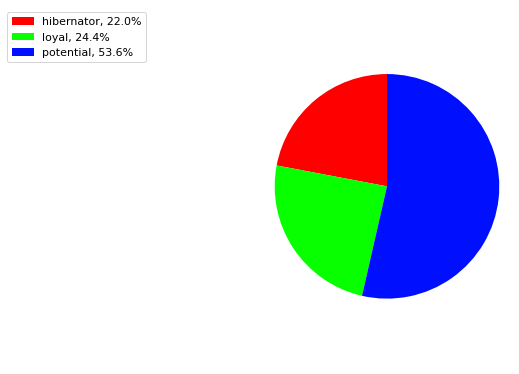

In [221]:
sizes =  u_s.values
labels = u_s.keys()
theme = plt.get_cmap('hsv')
show_pie_chart(sizes,labels,theme)


## Product Insights

In [147]:
product_data = pd.read_csv('products.csv')


In [26]:
product_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7062 entries, 0 to 7061
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   _id                      7062 non-null   float64
 1   additional_image         6749 non-null   object 
 2   adult                    7062 non-null   object 
 3   availability_date        0 non-null      float64
 4   avlble                   7062 non-null   int64  
 5   brand                    7062 non-null   object 
 6   business_unit            7062 non-null   object 
 7   category                 1335 non-null   object 
 8   collection               2849 non-null   object 
 9   color                    0 non-null      float64
 10  condition                7062 non-null   object 
 11  created_on               7062 non-null   float64
 12  currency                 7062 non-null   object 
 13  currency_symbol          7062 non-null   object 
 14  description             

In [181]:
# product_data = product_data['_id'].map(int)

filtered_product = product_data[['_id','avlble','category','subcategories','mfr_code','description']].replace(np.nan,'unknown', regex=True)
filtered_product

_id  avlble            category subcategories        mfr_code  \
0     1.969160e+37       0             unknown      Jeweller  502998SBHAAA04   
1     9.450330e+37       1  tq-mia-collections     Jewellery  552819GAHAAACZ   
2     6.910120e+37       1             unknown       Diamond  502999FSZLAA02   
3     1.111910e+38       1             unknown      Jeweller  505001SDWAGA09   
4     2.911930e+38       1             unknown      Jeweller  511183NVYAAA18   
...            ...     ...                 ...           ...             ...   
7057  3.181910e+38       1             unknown      Jeweller  511300DFCABA00   
7058  1.603650e+38       1             unknown      Jeweller  510976CKAECA00   
7059  2.482970e+38       1             unknown      Jeweller  502998PRGAAA09   
7060  1.083700e+38       1             unknown      Jeweller  512214SKMAAA00   
7061  2.769190e+38       1             unknown      Jeweller  511518PLFAAA00   

                                            description  
0           Tanishq 18KT Gold and Diamond Stud Earrings  
1     Mia by Tanishq Scorpio 14KT Rose Gold Pendant ...  
2        Tanishq 18KT Rose Gold and Diamond Finger Ring  
3      Tanishq 18KT Gold and Diamond Earrings for Women  
4     22KT Yellow Gold and Ruby Neckwear in Floral D...  
...                                                 ...  
7057  Tanishq 22KT Yellow Gold Drop Earrings with Pa...  
7058                            Tanishq 22KT Gold Chain  
7059              Tanishq 18KT Gold and Diamond Pendant  
7060   Tanishq 22KT Yellow Gold Stud Earrings for Women  
7061                          Tanishq 22KT Gold Pendant  

[7062 rows x 6 columns]

In [153]:
unique_categories = filtered_product['category'].drop_duplicates()
category_insights = filtered_product.groupby("category").size()



In [154]:
category_insights


category
Collections            299
Gifting                  1
Jeweller               159
Jewellery               66
Jewellery Type           5
Mia                    119
Silver                  19
tq-mia-category        639
tq-mia-collections      12
tq-occasion             16
unknown               5727
dtype: int64

In [190]:
# Trying to add more category to unknown 
# Find and replace strings in description and add category
# Ring -> Ring category
# Designs -> Designs

# filtered_product.loc[filtered_product['description'].str.contains('design',na=False,case=False), 'category'] = "Designs"
# filtered_product.loc[filtered_product['category'].str.contains('collections',na=False,case=False), 'category'] = "Mia"

category_insights = filtered_product.groupby("category").size()
category_insights
# filtered_product
# filtered_product.loc[filtered_product['category']=='c']
# filtered_product['diamond_clarity'].str.contains('S')

category
Chain           206
Collections      35
Designs        1146
Gifting          15
Mia             194
Pendant         996
Ring           3770
unknown         700
dtype: int64

In [ ]:
product_sub_categories

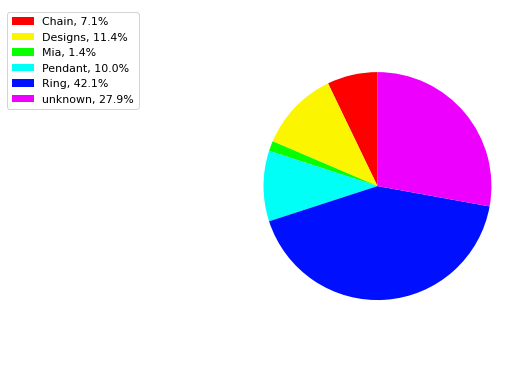

In [222]:
# Checking percentage of categories available
sizes =  category_insights.values
labels = category_insights.keys()
theme = plt.get_cmap('hsv')
show_pie_chart(sizes,labels,theme)


In [223]:
# Combining categories and subcategories in to one dataset
product_data.head()

_id                                   additional_image adult  \
0  1.969160e+37  https://staticimg.titan.co.in/Tanishq/Catalog/...    No   
1  9.450330e+37  https://staticimg.titan.co.in/Mia/Catalog/5528...    No   
2  6.910120e+37  https://staticimg.titan.co.in/Tanishq/Catalog/...    No   
3  1.111910e+38  https://staticimg.titan.co.in/Tanishq/Catalog/...    No   
4  2.911930e+38  https://staticimg.titan.co.in/Tanishq/Catalog/...    No   

   availability_date  avlble    brand business_unit            category  \
0                NaN       0  Tanishq     Jewellery                 NaN   
1                NaN       1      MIA     Jewellery  tq-mia-collections   
2                NaN       1  Tanishq     Jewellery                 NaN   
3                NaN       1  Tanishq     Jewellery                 NaN   
4                NaN       1  Tanishq     Jewellery                 NaN   

                collection  color  ... sale_price_usd  status     sub_account  \
0                      NaN    NaN  ...          61.42  Active       [tanishq]   
1  Mia Birthstone Pendants    NaN  ...         227.07  Active  [tanishq, mia]   
2             Contemporary    NaN  ...         161.21  Active       [tanishq]   
3                      NaN    NaN  ...         107.84  Active       [tanishq]   
4                      NaN    NaN  ...        2813.45  Active       [tanishq]   

  subcategories trendrank         unit updated  \
0      Jeweller       NaN          NaN   False   
1     Jewellery       1.0  millimeters   False   
2       Diamond       NaN          NaN   False   
3      Jeweller      30.0          NaN   False   
4      Jeweller       1.0          NaN   False   

                                                 url  \
0  /product/tanishq-18kt-gold-and-diamond-stud-ea...   
1               /product/chain-pendant-552819gahaacz   
2  /product/tanishq-18kt-rose-gold-and-diamond-fi...   
3  /product/tanishq-18kt-gold-and-diamond-earring...   
4  /product/22kt-gold-and-ruby-neckwear-in-a-flor...   

                                            variants    width  
0  {u'2JA000003': {u'price': 4431.0, u'listprice'...      NaN  
1  {u'2BD000278': {u'price': 16149.0, u'listprice...      NaN  
2  {u'2JA005106': {u'price': 11493.0, u'listprice...  16.4 mm  
3  {u'2BD005443': {u'price': 7688.0, u'listprice'...      NaN  
4  {u'2BA805635': {u'price': 200571.0, u'listpric...      NaN  

[5 rows x 60 columns]

In [224]:
X_train.head()

action_type user_type               epoch       object_id  \
19        add_to_cart     guest 2019-11-30 11:35:14  51T340FCSBAA00   
158          register     email 2019-11-29 01:49:05         5785097   
92    add_to_wishlist     email 2019-11-28 06:01:34  600102ZBARAS00   
79    add_to_wishlist     email 2019-11-29 07:34:32  511160CZHEAA00   
247  remove_from_cart     email 2019-11-27 08:08:09        3201NL01   

         user_id       sid                                             og_url  \
19           NaN  0.682919  https://www.tanishq.co.in/product/tanishq-22kt...   
158      5785097  0.411905  https://www.tanishq.co.in/myaccount/login?url=...   
92    5.3475e+06  0.829964  https://www.tanishq.co.in/product/10-gm-24kt-g...   
79       5786297  0.127951  https://www.tanishq.co.in/product/tanishq-22kt...   
247  5.70330e+06  0.492678                    https://www.tanishq.co.in/cart/   

             tt_id sub_account utm_source utm_campaign   utm_medium  \
19   1575113680178     tanishq     criteo          cca  retargeting   
158  1574991567964     tanishq        NaN          NaN          NaN   
92   1573796951607     tanishq        NaN          NaN          NaN   
79   1575011739788     tanishq        NaN          NaN          NaN   
247  1574833541978     tanishq        NaN          NaN          NaN   

              referrer utm_content  latitude  longitude  \
19   ads.as.criteo.com         NaN   12.9833    77.5833   
158                NaN         NaN   26.7161    88.4236   
92                 NaN         NaN   12.9833    77.5833   
79                 NaN         NaN   28.6014    77.1989   
247                NaN         NaN   20.0000    77.0000   

                                             useragent variant_id  \
19   Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...  2EA005231   
158  Mozilla/5.0 (Linux; Android 9; CPH1823 Build/P...        NaN   
92   Mozilla/5.0 (Windows NT 10.0; Win64; x64) Appl...        NaN   
79   Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...  2EE005513   
247  Mozilla/5.0 (Windows NT 6.1; Win64; x64) Apple...        NaN   

     order_placed  
19            NaN  
158           NaN  
92            NaN  
79            NaN  
247           NaN

In [45]:
# Exporting Train dataset to csv
X_train.to_csv('/home/ajit/train.csv',index=False)

In [256]:
X_train.loc[X_train['action_type']=='place_order']

ta = X_train[['action_type','tt_id','object_id']]
pa = filtered_product

### Merging Product data and user history data

In [257]:
# Combining object id with mfr code if value matches
combined_data = pd.merge(ta,pa,left_on="object_id",right_on="mfr_code",how='left')

combined_data

action_type          tt_id       object_id           _id  avlble  \
0         add_to_cart  1575113680178  51T340FCSBAA00  9.966750e+37     1.0   
1            register  1574991567964         5785097           NaN     NaN   
2     add_to_wishlist  1573796951607  600102ZBARAS00  1.954350e+38     1.0   
3     add_to_wishlist  1575011739788  511160CZHEAA00  1.937040e+38     1.0   
4    remove_from_cart  1574833541978        3201NL01           NaN     NaN   
..                ...            ...             ...           ...     ...   
207          register  1573568304225         5776302           NaN     NaN   
208   add_to_wishlist  1574662258922  512311PPFAAA00  2.252350e+38     1.0   
209       place_order  1575121846708  512714JOYABA00  1.991450e+38     0.0   
210              view  1575000265803  511517YIAGAA00  3.011190e+38     1.0   
211       place_order  1567522731961  600102ZBARAS00  1.954350e+38     1.0   

    category subcategories        mfr_code  \
0       Ring      Jeweller  51T340FCSBAA00   
1        NaN           NaN             NaN   
2    unknown      Jeweller  600102ZBARAS00   
3      Chain          Gold  511160CZHEAA00   
4        NaN           NaN             NaN   
..       ...           ...             ...   
207      NaN           NaN             NaN   
208  Designs      Jeweller  512311PPFAAA00   
209  unknown      Jeweller  512714JOYABA00   
210  unknown      Jeweller  511517YIAGAA00   
211  unknown      Jeweller  600102ZBARAS00   

                                           description  
0                        Tanishq 22KT Gold Finger Ring  
1                                                  NaN  
2               10 gm 24KT Gold Coin with Tanishq Logo  
3                              Tanishq 22KT Gold Chain  
4                                                  NaN  
..                                                 ...  
207                                                NaN  
208  Tanishq 22KT Yellow Gold Pendant with Tirupati...  
209                          Tanishq 22KT Gold Jhumkas  
210                      Tanishq 22KT Gold Mangalsutra  
211             10 gm 24KT Gold Coin with Tanishq Logo  

[212 rows x 9 columns]

In [258]:
category_insights = combined_data.groupby("category").size()
category_insights

category
Chain      10
Designs    16
Mia         2
Pendant    14
Ring       59
unknown    39
dtype: int64

In [259]:
combined_data
# combined_data.loc[combined_data['action_type']=='place_order']
# df.B.unique()
d = combined_data.subcategories.unique()
d

array(['Jeweller', nan, 'Gold', 'Greatdiamondsale', 'Jewellery',
       'Diamond', 'Electrify', 'Mia Classics'], dtype=object)

In [260]:
# Finding each category actions

# Get actions done on each category
def viewed(action):
    if "view" in action.values:    
        return action.keys()[0]
    else:
        return 0
    
def purchased(action):
    if "place_order" in action.values: 
        return action.keys()[0]
    else:
        return 0
    
def wishlist(action):
    if "add_to_wishlist" in action.values: 
        return action.keys()[0]
    else:
        return 0

    
ua_by_category = combined_data.groupby('category').agg(
    viewed =pd.NamedAgg(column="action_type",aggfunc=viewed),
    purchased =pd.NamedAgg(column="action_type",aggfunc=purchased),
    wishlist =pd.NamedAgg(column="action_type",aggfunc=wishlist),
)




## Most Viewed, Purchased, Wishlist Categories

In [261]:
ua_by_category

viewed  purchased  wishlist
category                             
Chain          3          0         3
Designs        0         53        53
Mia            0          0         0
Pendant        0         28        28
Ring           0          0         0
unknown        2          2         2

# Identifying the major factors affecting users' buying decisions. 

In [265]:
# Understanding which factors affects the buyers decisions

xy = combined_data.loc[combined_data['action_type']=='place_order']
xy

action_type          tt_id       object_id           _id  avlble  \
9    place_order  1556635697710  552811SYAAAA00  1.256460e+38     1.0   
26   place_order  1574848138072  552817SABAAA00  2.508440e+38     0.0   
30   place_order  1575032098766  552817DBAAAA00  2.418810e+38     1.0   
32   place_order  1556696450282  512P15SKMAGA00  1.685280e+38     1.0   
36   place_order  1571289338350  500067SYAABA13  1.576410e+38     1.0   
38   place_order  1572217537029  51T436OBEAHACZ  8.293260e+36     1.0   
43   place_order  1572521837337  600102ZNARAS00  3.360280e+38     1.0   
45   place_order  1574848601674  502117FDIMAA09  3.291550e+38     1.0   
54   place_order  1574533872512  512219PKMAAA00  1.415900e+38     1.0   
57   place_order  1572331918684  501191OAHABA02  3.282720e+37     1.0   
60   place_order  1557396318783  600105ZGBRAS00  3.030030e+38     1.0   
65   place_order  1573873720571  511003FBGMAA00  2.036190e+38     1.0   
68   place_order  1574750715471  514115PNRAAA00  1.154170e+38     0.0   
81   place_order  1574783207983  513C17FIFOAA00  1.798620e+38     0.0   
83   place_order  1575056595357  500063PLAAAA11  1.692190e+38     1.0   
93   place_order  1574925093699  513013HVPAAA00  1.314280e+38     0.0   
96   place_order  1574846710017  510433SEAAGA00  2.869830e+38     1.0   
101  place_order  1563448681396  511887PBDAAA00  1.574320e+38     1.0   
104  place_order  1574750715471  510166PHAAAA00  1.168700e+38     0.0   
120  place_order  1573095107218  501169OAAABA09  2.642260e+38     0.0   
126  place_order  1562961302380  502999SZZAAA22  2.067270e+38     0.0   
129  place_order  1574848138072  552817SABAAA00  2.508440e+38     0.0   
130  place_order  1574784788622  552819PJRAAA00  7.085480e+37     0.0   
141  place_order  1574914104769  501718SFIAAA09  2.878430e+38     0.0   
147  place_order  1574393666877  502998SAEAAA22  2.086220e+38     1.0   
161  place_order  1574784788622  552818GIOAAA22  4.402900e+35     1.0   
178  place_order  1557140337599  503416PHZAAA09  3.311510e+38     1.0   
198  place_order  1563776928202  510802DAAAGA00  6.185440e+37     1.0   
199  place_order  1574556410434  500063OFAABA02  2.066800e+36     0.0   
204  place_order  1574848138072  552817SABAAA00  2.508440e+38     0.0   
209  place_order  1575121846708  512714JOYABA00  1.991450e+38     0.0   
211  place_order  1567522731961  600102ZBARAS00  1.954350e+38     1.0   

    category subcategories        mfr_code  \
9       Ring     Jewellery  552811SYAAAA00   
26      Ring     Jewellery  552817SABAAA00   
30      Ring     Jewellery  552817DBAAAA00   
32      Ring      Jeweller  512P15SKMAGA00   
36      Ring      Jeweller  500067SYAABA13   
38   unknown      Jeweller  51T436OBEAHACZ   
43   unknown      Jeweller  600102ZNARAS00   
45      Ring      Jeweller  502117FDIMAA09   
54   Designs          Gold  512219PKMAAA00   
57   unknown      Jeweller  501191OAHABA02   
60   unknown      Jeweller  600105ZGBRAS00   
65      Ring      Jeweller  511003FBGMAA00   
68   Designs      Jeweller  514115PNRAAA00   
81      Ring      Jeweller  513C17FIFOAA00   
83   Pendant      Jeweller  500063PLAAAA11   
93      Ring      Jeweller  513013HVPAAA00   
96      Ring          Gold  510433SEAAGA00   
101  Pendant      Jeweller  511887PBDAAA00   
104  Pendant      Jeweller  510166PHAAAA00   
120  unknown      Jeweller  501169OAAABA09   
126     Ring       Diamond  502999SZZAAA22   
129     Ring     Jewellery  552817SABAAA00   
130  Designs     Electrify  552819PJRAAA00   
141     Ring      Jeweller  501718SFIAAA09   
147  Designs       Diamond  502998SAEAAA22   
161  Pendant     Jewellery  552818GIOAAA22   
178  Designs       Diamond  503416PHZAAA09   
198     Ring      Jeweller  510802DAAAGA00   
199  unknown      Jeweller  500063OFAABA02   
204     Ring     Jewellery  552817SABAAA00   
209  unknown      Jeweller  512714JOYABA00   
211  unknown      Jeweller  600102ZBARAS00   

                                           description  
9                  